In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import yaml
import tqdm
import json
import torch
import hydra
import pprint
import logging
import colorlog
import src.prepare  # noqa
import logging.config

import numpy as np
import pytorch_lightning as pl

from src.config import read_config
from hydra.utils import instantiate
from src.load import load_model_from_cfg
from omegaconf import OmegaConf, DictConfig
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

/home/nadir/disk/codes/tmr-code/.tmr.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:

LOGGING_CONFIG = {
    'version': 1,
    'disable_existing_loggers': False,
    'formatters': {
        'simple': {
            'format': '[%(asctime)s][%(name)s][%(levelname)s] - %(message)s',
            'datefmt': '%d/%m/%y %H:%M:%S',
        },
        'colorlog': {
            '()': 'colorlog.ColoredFormatter',
            'format': '[%(white)s%(asctime)s%(reset)s] %(log_color)s%(levelname)s%(reset)s   %(message)s',
            'datefmt': '%d/%m/%y %H:%M:%S',
            'log_colors': {
                'DEBUG': 'purple',
                'INFO': 'blue',
                'WARNING': 'yellow',
                'ERROR': 'red',
                'CRITICAL': 'red',
            },
        },
    },
}

logging.config.dictConfig(LOGGING_CONFIG)

logger = logging.getLogger(__name__)

logger.info("logger has been configured.")

<div class="alert alert-info">

**source:** [hydra configurations in a notebook](https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb).

</div>

In [7]:
RUN_DIRS = [
    # "/home/nadir/disk/codes/tmr-code/outputs/classifier_babel-classifier_guoh3dfeats_16",
    # "/home/nadir/disk/codes/tmr-code/outputs/classifier_babel-classifier_guoh3dfeats_32",
    # "/home/nadir/disk/codes/tmr-code/outputs/classifier_babel-classifier_guoh3dfeats_64",
    "/home/nadir/disk/codes/tmr-code/outputs/classifier_babel-classifier_guoh3dfeats_128",
    "/home/nadir/disk/codes/tmr-code/outputs/classifier_babel-classifier_guoh3dfeats_256",
    # "/home/nadir/disk/codes/tmr-code/outputs/classifier_babel-classifier_guoh3dfeats_512",
]

In [8]:
with initialize(
    version_base=None,
    config_path="configs",
    # 
):
    # config = compose(overrides=["+db=mysql"])
    config = compose(
        config_name="evaluate-classifier-segmentation",
        return_hydra_config=True,
        overrides=[f"run_dir={RUN_DIRS[0]}"]
    )
    
    from hydra.core.hydra_config import HydraConfig
    
    HydraConfig.instance().set_config(config)
    
print(OmegaConf.to_yaml(config, sort_keys=False))

hydra:
  run:
    dir: ${run_dir}
  sweep:
    dir: multirun/${now:%Y-%m-%d}/${now:%H-%M-%S}
    subdir: ${hydra.job.num}
  launcher:
    _target_: hydra._internal.core_plugins.basic_launcher.BasicLauncher
  sweeper:
    _target_: hydra._internal.core_plugins.basic_sweeper.BasicSweeper
    max_batch_size: null
    params: null
  help:
    app_name: ${hydra.job.name}
    header: '${hydra.help.app_name} is powered by Hydra.

      '
    footer: 'Powered by Hydra (https://hydra.cc)

      Use --hydra-help to view Hydra specific help

      '
    template: '${hydra.help.header}

      == Configuration groups ==

      Compose your configuration from those groups (group=option)


      $APP_CONFIG_GROUPS


      == Config ==

      Override anything in the config (foo.bar=value)


      $CONFIG


      ${hydra.help.footer}

      '
  hydra_help:
    template: 'Hydra (${hydra.runtime.version})

      See https://hydra.cc for more info.


      == Flags ==

      $FLAGS_HELP


      == Config

In [9]:
def get_batch(dataloader, index):
    for i, batch in tqdm.tqdm(iterable=enumerate(dataloader), total=index, desc="[loading]"):
        if i == index:
            break
    
    return batch

In [10]:
def prepare(run_dir, with_seeding=True):
    device = config.device
    # run_dir = config.run_dir
    examples = config.examples
    ckpt_name = config.ckpt

    # NOTE: moved up here in order to use the segmentation config for the dataset
    # defined in the config file rather than the config used to train the model
    dataset = instantiate(config.data, split="test")

    logger.info(f"[run_dir]: {run_dir}")

    # NOTE: will load the config used to train the model
    cfg = read_config(run_dir)

    if with_seeding:
        pl.seed_everything(cfg.seed)

    logger.info("[model]: loading")
    model = load_model_from_cfg(cfg, ckpt_name, eval_mode=True, device=device)

    logger.info(f"[dataset.mode]: {dataset.mode}")

    dataloader = instantiate(
        cfg.dataloader,
        dataset=dataset,
        collate_fn=dataset.collate_fn,
        shuffle=False,
    )
    
    model = model.eval()
    
    return model, dataloader, dataset, device

In [15]:
from src.model.metrics import get_segments

def remove_short_segments(labels, min_duration=5):
    """
    Remove segments shorter than min_duration from label sequence.
    Short segments are replaced by the previous valid label.
    """
    segments = get_segments(labels)
    new_labels = []

    for i, (label, start, end) in enumerate(segments):
        duration = end - start
        if duration >= min_duration:
            new_labels.extend([label] * duration)
        else:
            # Replace with previous label if available, else next, else zero
            if i > 0:
                fill_label = segments[i - 1][0]
            elif i < len(segments) - 1:
                fill_label = segments[i + 1][0]
            else:
                fill_label = 0  # fallback
            new_labels.extend([fill_label] * duration)

    return new_labels

[model]: 128
[index]: 83


[loading]: 100%|██████████| 83/83 [00:12<00:00,  6.67it/s]


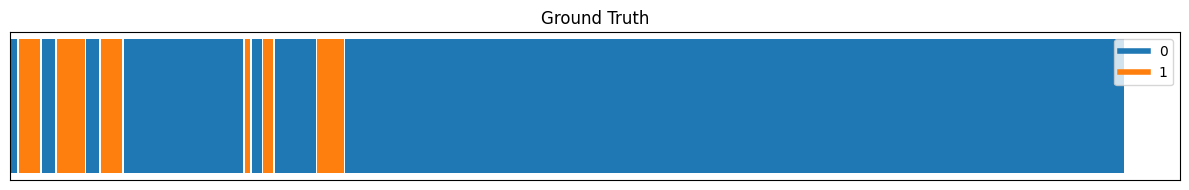

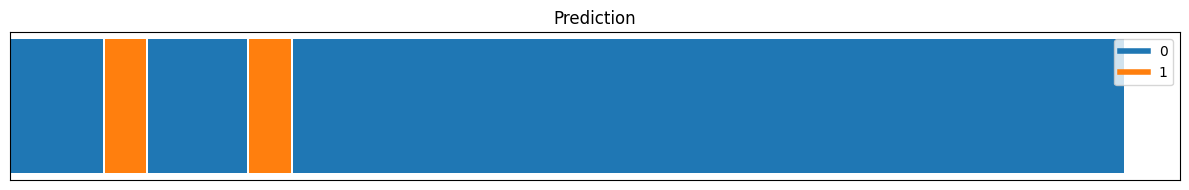

--- --- --- --- --- --- ---


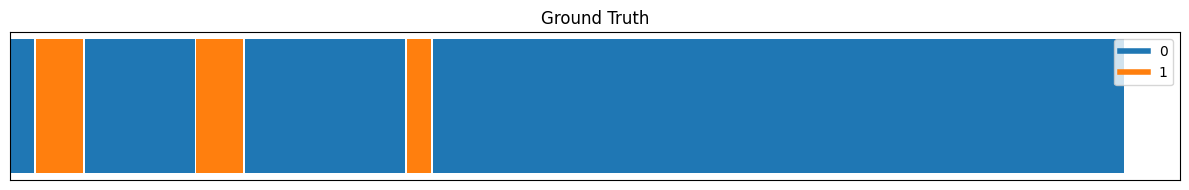

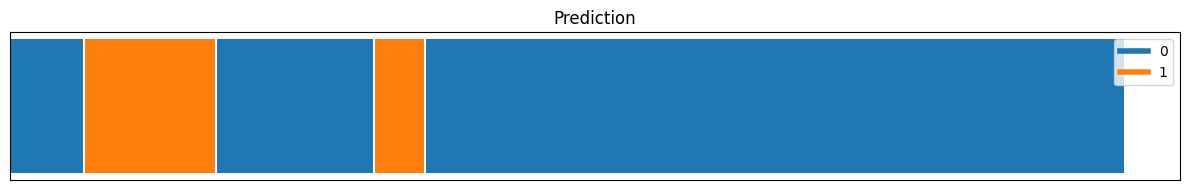

--- --- --- --- --- --- ---


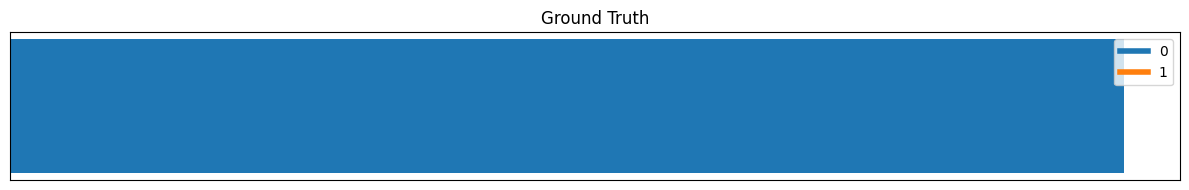

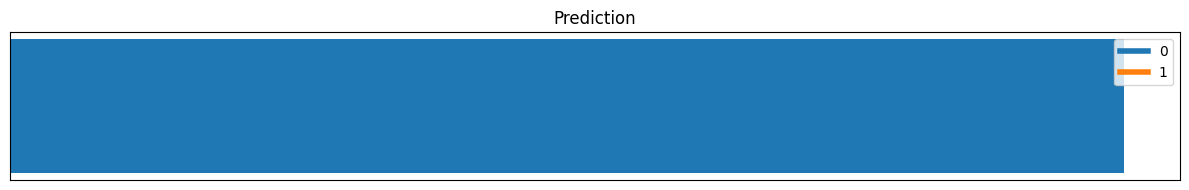

--- --- --- --- --- --- ---


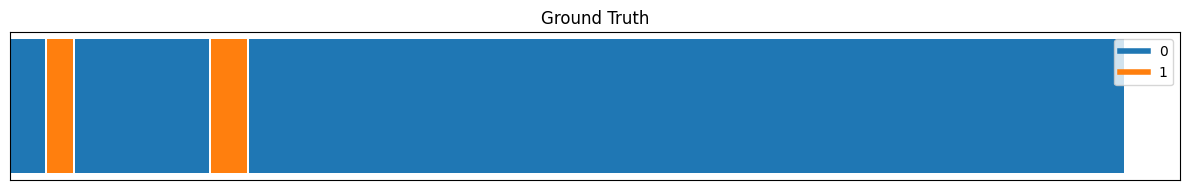

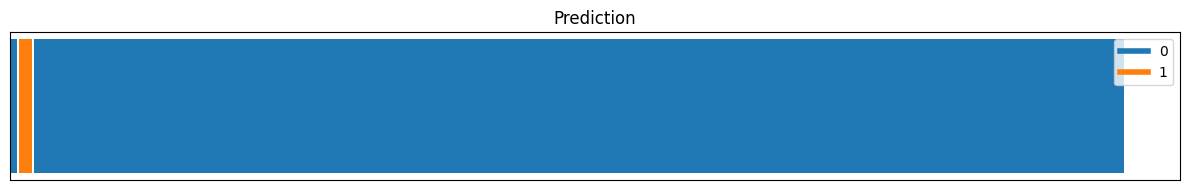

--- --- --- --- --- --- ---


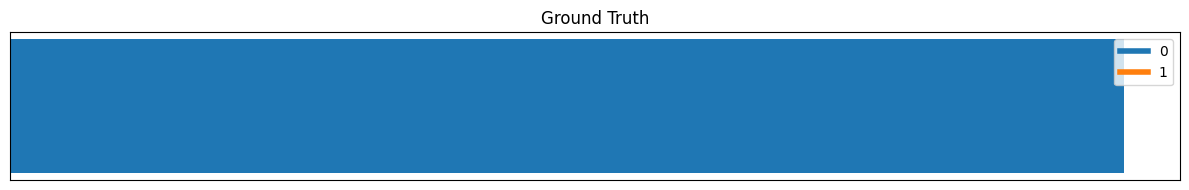

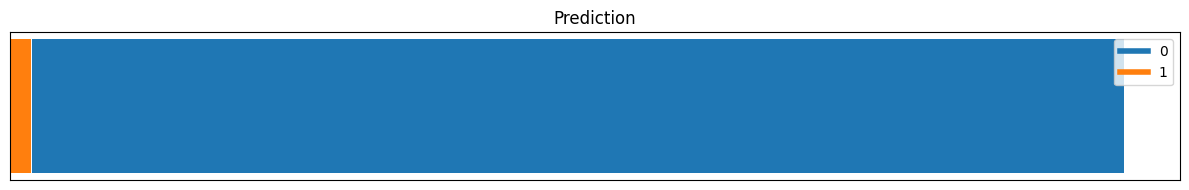

--- --- --- --- --- --- ---


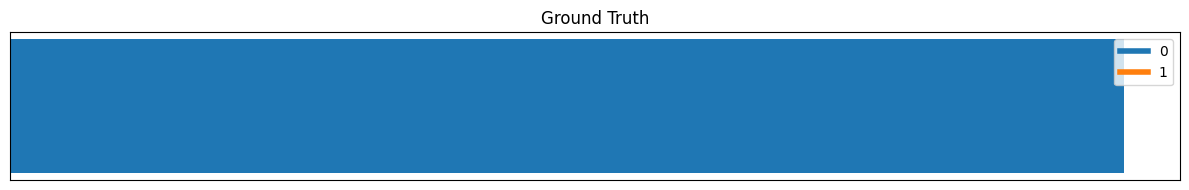

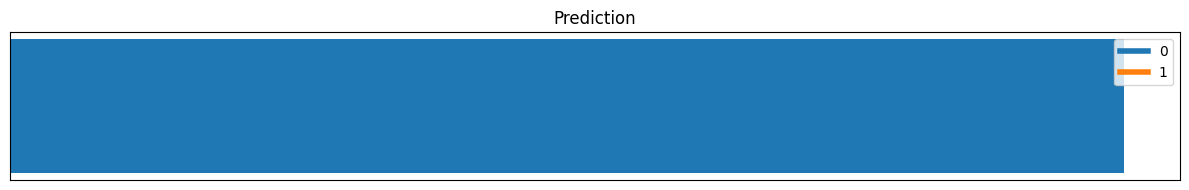

--- --- --- --- --- --- ---


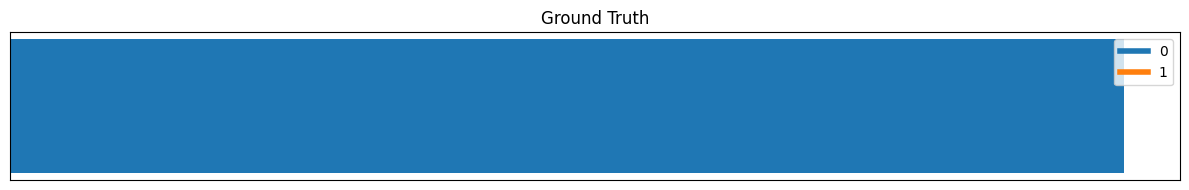

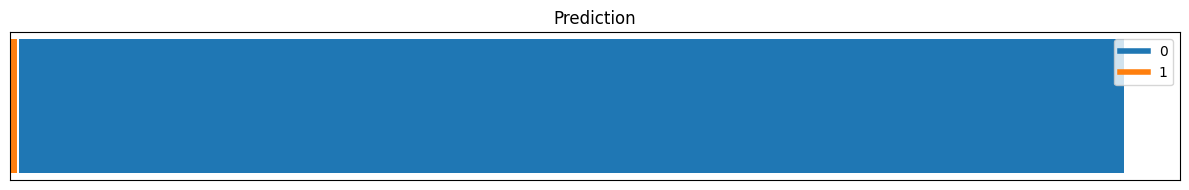

--- --- --- --- --- --- ---


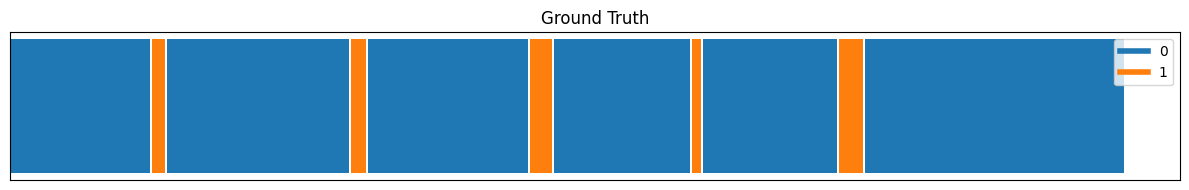

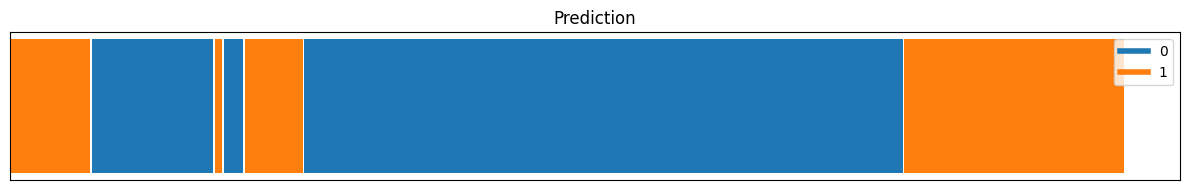

--- --- --- --- --- --- ---


In [ ]:
model, dataloader, dataset, device = prepare(run_dir=RUN_DIRS[0], with_seeding=False)

print(f"[model]: {RUN_DIRS[0].split('_')[-1]}")

index = np.random.randint(0, len(dataloader))

print(f"[index]: {index}")

batch = get_batch(dataloader, index)

batch["annotation"] = batch["annotation"].to(device)

batch["motion_x_dict"]["x"] = batch["motion_x_dict"]["x"].to(device)
batch["motion_x_dict"]["mask"] = batch["motion_x_dict"]["mask"].to(device)

x = batch["motion_x_dict"]
y = batch["annotation"]

outputs = model.segment_sequence(
    motion_x_dict=x,
    window_size=30,
    window_step=1
)

predictions = outputs.cpu().numpy()
predictions = [remove_short_segments(seq, min_duration=5) for seq in predictions]

labels = y.squeeze(1).cpu().numpy()

import matplotlib.pyplot as plt
from tas_helpers.visualization import SegmentationVisualizer
from tas_helpers.utils import generate_random_segmentation, frame_level_annotations_to_segment_level_annotations


visualizer = SegmentationVisualizer(
    labels_values=[0, 1],
)
    
for prediction, label in zip(predictions, labels):
    # print(f"[prediction]: {frame_level_annotations_to_segment_level_annotations(prediction, fps=20)}")
    # print(f"[label]: {frame_level_annotations_to_segment_level_annotations(label, fps=20)}")
    segmentation_1 = frame_level_annotations_to_segment_level_annotations(prediction, fps=20)
    segmentation_2 = frame_level_annotations_to_segment_level_annotations(label, fps=20)
    
    visualizer.plot_segmentation(
        label, 
        header="Ground Truth", 
        fps=20,
        show_ticks=False
    )

    plt.show()
    
    visualizer.plot_segmentation(
        prediction, 
        header="Prediction", 
        fps=20,
        show_ticks=False
    )

    plt.show()
    
    print("--- --- --- --- --- --- ---")

In [17]:
def transition_count_accuracy(preds, gts):
    """
    Computes the accuracy of transition count prediction.
    Each sequence is compared based on the number of segments (i.e., transitions + 1).
    Returns the mean accuracy across the dataset.
    """
    accuracies = []
    for pred, gt in zip(preds, gts):
        pred_n_trans = len(get_segments(pred))
        gt_n_trans = len(get_segments(gt))
        acc = 1.0 if pred_n_trans == gt_n_trans else 0.0
        accuracies.append(acc)
    return np.mean(accuracies)

In [ ]:
for run_dir in RUN_DIRS:
    try:
        print(f"[model-variant]: {run_dir.split('_')[-1]}")
        
        model, dataloader, dataset, device = prepare(run_dir=run_dir)

        all_preds, all_labels = [], []

        with torch.no_grad():
            for index, batch in tqdm.tqdm(iterable=enumerate(dataloader), total=len(dataloader), desc="[evaluate-segmentation]"):
                batch["annotation"] = batch["annotation"].to(device)
                
                batch["motion_x_dict"]["x"] = batch["motion_x_dict"]["x"].to(device)
                batch["motion_x_dict"]["mask"] = batch["motion_x_dict"]["mask"].to(device)
                
                x = batch["motion_x_dict"]
                y = batch["annotation"]
                
                outputs = model.segment_sequence(
                    motion_x_dict=x,
                    window_size=20,
                    window_step=1
                )
                
                preds = outputs.cpu().numpy()
                labels = y.squeeze(1).cpu().numpy()
                
                for pred_seq, label_seq in zip(preds, labels):
                    all_preds.append(pred_seq)
                    all_labels.append(label_seq)

        acc_list = []
        edit_list = []
        
        # NOTE: post-processing
        all_preds = [remove_short_segments(seq, min_duration=5) for seq in all_preds]

        f1_thresholds = np.arange(0.1, 1.1, 0.1)
        f1_scores = []

        from src.model.metrics import accuracy_score, levenshtein, f_score

        for pred_seq, label_seq in zip(all_preds, all_labels):
            acc = accuracy_score(label_seq, pred_seq)
            edit = levenshtein(pred_seq, label_seq)
            
            f1_thresholds_scores = []
            
            for threshold in f1_thresholds:
                f1_thresholds_scores.append(f_score(pred_seq, label_seq, overlap=threshold))

            acc_list.append(acc)
            edit_list.append(edit)
            f1_scores.append(f1_thresholds_scores)

        print("Frame-wise Accuracy: {:.2f}%".format(100 * np.mean(acc_list)))
        print("Edit Score: {:.2f}%".format(100 * np.mean(edit_list)))
        trans_acc = transition_count_accuracy(all_preds, all_labels)
        print(f"Transition Count Accuracy: {trans_acc * 100:.2f}%")

        for i, threshold in enumerate(f1_thresholds):
            scores = [f1_scores[j][i] for j in range(len(f1_scores))]
            print(f"F1@{threshold:.2f}: {100 * np.mean(scores):.2f}%")
            
        print("--- --- --- --- --- --- ---\n\n\n\n")
        
    except Exception as exception:
        print("[exception]:", exception)

Global seed set to 1234


[model-variant]: 128


[evaluate-segmentation]: 100%|██████████| 111/111 [00:17<00:00,  6.17it/s]
Global seed set to 1234


Frame-wise Accuracy: 94.81%
Edit Score: 94.91%
Transition Count Accuracy: 43.76%
F1@0.10: 63.63%
F1@0.20: 62.90%
F1@0.30: 62.10%
F1@0.40: 61.00%
F1@0.50: 60.01%
F1@0.60: 58.49%
F1@0.70: 56.96%
F1@0.80: 54.28%
F1@0.90: 50.36%
F1@1.00: 42.06%
--- --- --- --- --- --- ---




[model-variant]: 256


[evaluate-segmentation]: 100%|██████████| 111/111 [00:17<00:00,  6.49it/s]


Frame-wise Accuracy: 96.19%
Edit Score: 96.20%
Transition Count Accuracy: 51.36%
F1@0.10: 67.22%
F1@0.20: 66.94%
F1@0.30: 66.54%
F1@0.40: 66.02%
F1@0.50: 65.35%
F1@0.60: 64.09%
F1@0.70: 62.71%
F1@0.80: 60.42%
F1@0.90: 57.07%
F1@1.00: 51.25%
--- --- --- --- --- --- ---




